# SynthTabNet Dataset

SynthTabNet is a dataset of 600k `png` images from synthetically generated table layouts with annotations in `jsonl` files.

The dataset is open sourced by IBM Research Zurich and is freely available to download on [GitHub](https://github.com/IBM/SynthTabNet)

## Download the files

We have prepared a small subset of SynthTabNet called `samples`. The following code simply downloads it and unzips it in a local directory.

In [1]:
import os
import json
import jsonlines
import zipfile
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, HTML

samples_url = "https://ds4sd-public-artifacts.s3.eu-de.cloud-object-storage.appdomain.cloud/datasets/synthtabnet_public/samples.zip"
samples_fn = "samples.zip"

# Download and extract the samples
# Path(samples_dir).mkdir(parents=True, exist_ok=True)
print("Downloading...")
req = requests.get(samples_url)
print("Saving...")
open(samples_fn, "wb").write(req.content)
print("Extracting...")
zipfile.ZipFile(samples_fn, "r").extractall(".")
print("Done")

Downloading...
Saving...
Extracting...
Done


## Show some example images

The next step is to visualize some random images among all dataset parts:

PubTabNet sample:


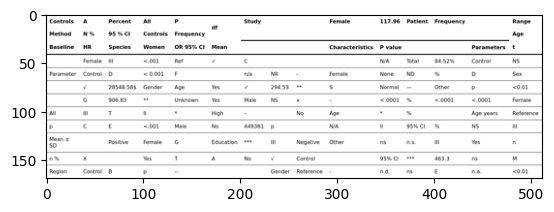

Sparse sample:


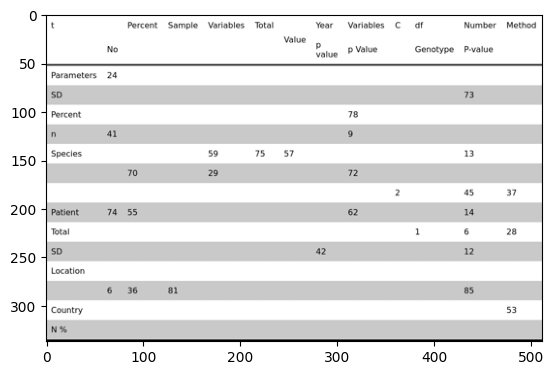

FinTabNet sample:


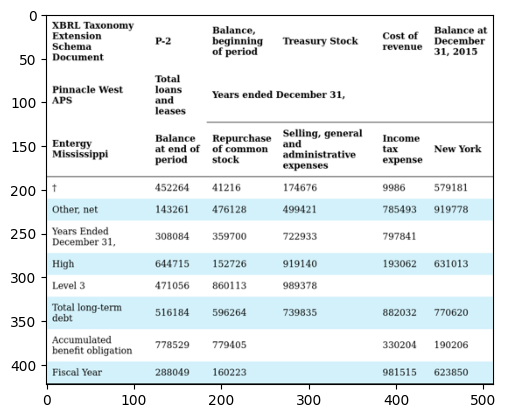

Marketing sample:


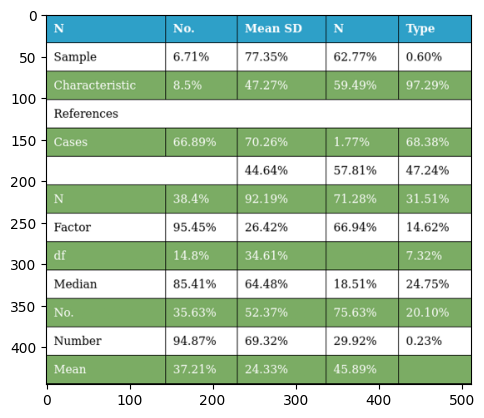

In [2]:
# Visualize images from each part of the dataset
img_fns = {
    "PubTabNet": "samples/pubtabnet/images/train/image_000005_1634629104.274936.png",
    "Sparse": "samples/sparse/images/train/image_000005_1634629370.551275.png",
    "FinTabNet": "samples/fintabnet/images/train/image_000014_1634629328.541362.png",
    "Marketing": "samples/marketing/images/train/image_000024_1634629424.186544.png"
}

for part_name, img_fn in img_fns.items():
    img = mpimg.imread(img_fn)
    imgplot = plt.imshow(img)
    print(f"{part_name} sample:")
    plt.show()

## Check the annotations

The `synthetic_data.jsonl` file contains the annotations for each part in [json lines format](https://jsonlines.org/)

More specifically:

- Each line of the file contains a `json` object with annotations for one image.
- The data format of each `json` object is described in [GitHub](https://github.com/IBM/SynthTabNet).

Let's check the first image of the `PubTabNet` part together with its annotation:

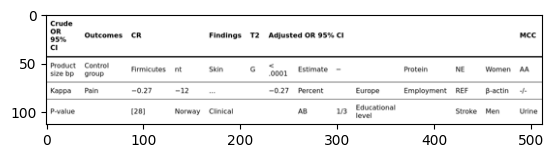

In [31]:
base_path = "samples/pubtabnet"
jsonl_fn = base_path + "/synthetic_data.jsonl"

with jsonlines.open(jsonl_fn, 'r') as jsonl_f:
     lst = [obj for obj in jsonl_f]
img_ann = lst[15]

# Show the corresponding image
img_filename = img_ann["filename"]
split = img_ann["split"]
img_fn = os.path.join( base_path + "/images", split, img_filename)
img = mpimg.imread(img_fn)
imgplot = plt.imshow(img)

In [32]:
# Print the annotation
img_ann_pretty = json.dumps(img_ann, sort_keys=True, indent="  ")
print(img_ann_pretty)

{
  "filename": "image_000015_1634629104.291594.png",
  "html": {
    "cells": [
      {
        "bbox": [
          4.357446808510638,
          5.671814671814672,
          27.594893617021278,
          38.83011583011583,
          2
        ],
        "cell_id": 0,
        "is_header": true,
        "tokens": [
          "C",
          "r",
          "u",
          "d",
          "e",
          " ",
          "O",
          "R",
          " ",
          "9",
          "5",
          "%",
          " ",
          "C",
          "I"
        ]
      },
      {
        "bbox": [
          39.65276595744681,
          17.88803088803089,
          78.93787234042553,
          26.17760617760618,
          2
        ],
        "cell_id": 1,
        "is_header": true,
        "tokens": [
          "O",
          "u",
          "t",
          "c",
          "o",
          "m",
          "e",
          "s"
        ]
      },
      {
        "bbox": [
          88.0204255319149,
          17.88

Now let's use the annotations to reconstruct the table. This includes the following steps:

1. Use the elements of the `html.structure.tokens` array to build the table structure.
2. Use the `tokens` of each `cell` to populate the cell content.
3. (Optional). Use the `bbox` of each `cell` to get the bounding box coordinates and class.

The `format_html` function will help us to build html code out of the json annotations:

In [33]:
def format_html(ann: dict) -> str:
    r"""
    Formats annotations in html code
    """
    cells = ann["html"]["cells"]
    tokens = ann["html"]["structure"]["tokens"]
    table = []
    cell_idx = 0
    for token in tokens:
        if token.startswith("<td"):
            cell = cells[cell_idx]
            content = "".join(cell["tokens"])
            cell_idx += 1
        if token == "</td>":
            table.append(content)
        table.append(token)
    table_str = "".join(table)

    html_code = """<html>
    <head>
    <meta charset="UTF-8">
    <style>
    table, th, td {
      border: 1px solid black;
      font-size: 10px;
    }
    </style>
    </head>
    <body>
    <table frame="hsides" rules="groups" width="100%%">
    %s
    </table>
    </body>
    </html>""" % "".join(table_str)
    return html_code

Finally we can apply the `format_html` on the `img_ann` object and reconstruct the html code:

In [34]:
html_code = format_html(img_ann)
display(HTML(html_code))